## Determine max distance between sensors and each point on the planet
This distance map is used to computes the probability of detecting a given event across an entire sensor network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import compute_network_shapes_CPUs as cns

### Grid source locations

In [2]:
reload(cns)

dlon = 2.
lats, lons = np.arange(-90, 89, dlon/2.), np.arange(-180, 179, dlon)
LATS, LONS, shape_init = cns.get_grid(lats, lons)

In [3]:
reload(cns)
polys = cns.get_polys(LONS, LATS, dlon, R0=6052000)

### Balloons

In [5]:
reload(cns)

dlon_stations = 5.
lats, lons = np.arange(-90, 89, dlon/2.), np.arange(-180, 179, dlon)
lats_stations, lons_stations, id_scenario, id_stat = cns.get_stations(lats, lons, offsets=[[2., 4.]], fixed_stations=dict())

In [7]:
reload(cns)
max_dist = cns.get_max_dist(lats_stations, lons_stations, LATS, LONS, id_scenario, id_stat, s_cluster=100, use_airglow=False, which_stat_is_airglow=1, R_airglow=5000.*1e3,)

  0%|          | 0/323 [00:00<?, ?it/s]c:\Users\quentin\Documents\2024_Venus_Detectability\compute_network_shapes_CPUs.py:157: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
100%|██████████| 323/323 [13:30<00:00,  2.51s/it]


In [8]:
#max_dist = np.load('./max_dist.npy', mmap_mode='r')
with open('./max_dist_2_4.npy', 'wb') as f:
    np.save(f, max_dist)

### Airglow

In [ ]:
file_atmos = './data/profile_VCD_for_scaling_pd.csv'
profile = pd.read_csv(file_atmos)
f_rho = interpolate.interp1d(profile.altitude/1e3, profile.rho, kind='quadratic', bounds_error=False, fill_value=(profile.rho.min(), profile.rho.max()))
f_t = interpolate.interp1d(profile.altitude/1e3, profile.t, kind='quadratic')
f_gamma = interpolate.interp1d(profile.altitude/1e3, profile.gamma, kind='quadratic')

In [ ]:
import proba_modules as pm
reload(pm)
file_curve = './data/GF_Dirac_1Hz_all_wfreq.csv'
freq = 0.14
TL_new_p, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, freq, dist_min=100., rho0=f_rho(0.), rhob=f_rho(90.), use_savgol_filter=True, plot=True, scalar_moment=10e6, unknown='pressure')
TL_new_v, TL_new_qmin, TL_new_qmax = pm.get_TL_curves(file_curve, freq, dist_min=100., rho0=f_rho(0.), rhob=f_rho(90.), cb=f_c(90.), use_savgol_filter=True, plot=True, scalar_moment=10e6, unknown='velocity')

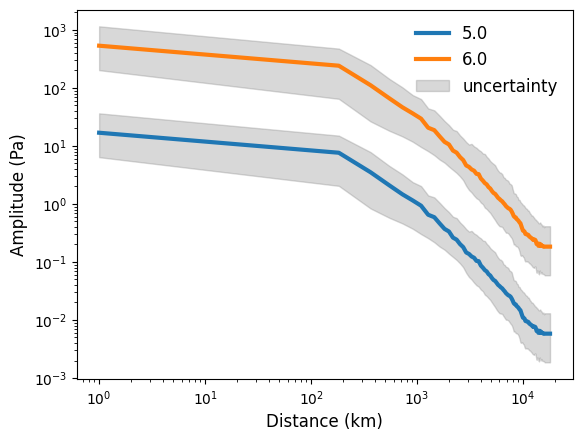

In [108]:
import compute_network_shapes_CPUs as cns
reload(cns)

file_airglow = './data/VER_profile_dayglow.csv'
VER = pd.read_csv(file_airglow)
VER.columns=['VER', 'alt']
VER.to_csv(file_airglow.replace('.csv', '_scaled.csv'), index=False)
boost_SNR = 1

photons_dayglow = 3.5e5
alpha = 1e-5
sigma_airglow = np.trapz(VER.VER, x=VER.alt.values,)/(np.sqrt(photons_dayglow)*boost_SNR)

photons_nightglow = 2e4
#alpha = maxs[-5]
#sigma_airglow = 1./(np.sqrt(photons_nightglow)*boost_SNR)

f_alt_scaling = cns.get_airglow_scaling(TL_new_v, TL_new_p, R0=6052000, sigma_balloon=1e-2, sigma_airglow=1e-1, m0=7., beta=1., alpha = 1e-5)

In [49]:
reload(cns)

dlon_stations = 5.
lats, lons = np.arange(-90, 89, dlon/2.), np.arange(-180, 179, dlon)
lats_stations, lons_stations, id_scenario, id_stat = cns.get_stations(lats, lons, offsets=[], fixed_stations=dict(scenario_1=[[0., 0.]]))

In [106]:
reload(cns)
max_dist = None
max_dist = cns.get_max_dist(lats_stations, lons_stations, LATS, LONS, id_scenario, id_stat, s_cluster=100, use_airglow=True, which_stat_is_airglow=1, R_airglow=5000., alt_scaling=f_r0)

  0%|          | 0/323 [00:00<?, ?it/s]c:\Users\quentin\Documents\2024_Venus_Detectability\compute_network_shapes_CPUs.py:155: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
100%|██████████| 323/323 [11:13<00:00,  2.09s/it]


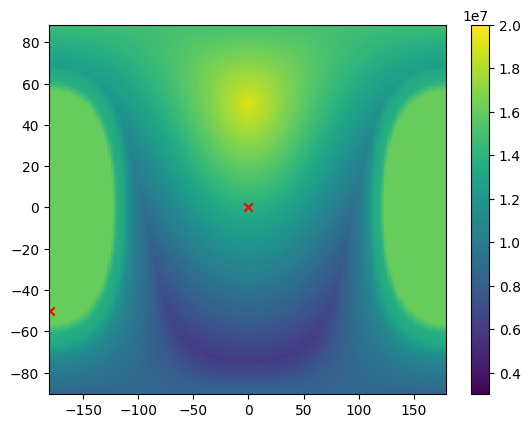

In [105]:
plt.figure()
id = 40
sc = plt.pcolormesh(lons, lats, max_dist[id,:].reshape(shape_init).T, vmin=0.3e7, vmax=2.e7)
plt.colorbar(sc)
plt.scatter(lons_stations[id,:], lats_stations[id,:], marker='x', color='red')

### Compute surface ratios

In [9]:
reload(cns)
plot = False
R0 = 6052000
thresholds = np.arange(10000, np.pi*R0/1.001, 5e5)[:]/1e3
gdf = cns.compute_surfaces_CPUs(thresholds, LATS, LONS, lats_stations, lons_stations, polys, plot, R0, max_dist, nb_CPU=1)

Running serial


  0%|          | 4/32220 [00:13<29:15:30,  3.27s/it]


KeyboardInterrupt: 

: 

In [29]:
gdf.to_file("./airglow_shp/airglow.shp")

C:\Users\quentin\AppData\Local\Temp\ipykernel_16484\120095355.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("./airglow_shp/airglow.shp")


In [31]:
import geopandas as gpd
gdf2=gpd.read_file(f"./airglow_shp/airglow.shp")